In [1]:
# VARIABLES

# defining the files directory and testing directory
files_dir = '/home/sam/data/ladi/dataset_for_model/TRAIN_IMAGES_AND_ANNOS'
width, height = 520,520
num_classes = 1
num_epochs = 20
test_split = 0.1

In [2]:
# Basic python and ML Libraries
import os
import random
import numpy as np
import pandas as pd
# for ignoring warnings
import warnings
warnings.filterwarnings('ignore')

# We will be reading images using OpenCV
import cv2

# xml library for parsing xml files
from xml.etree import ElementTree as et

# matplotlib for visualization
import matplotlib.pyplot as plt
import matplotlib.patches as patches

# torchvision libraries
import torch
import torchvision
from torchvision import transforms as torchtrans  
from torchvision.models.detection.faster_rcnn import FastRCNNPredictor

# these are the helper libraries imported.
from utilities.engine import train_one_epoch, evaluate
import utilities.utils
import utilities.transforms as T

# for image augmentations
import albumentations as A
from albumentations.pytorch.transforms import ToTensorV2

In [3]:
class FEMAImagesDataset(torch.utils.data.Dataset):

    def __init__(self, files_dir, width, height, transforms=None):
        self.transforms = transforms
        self.files_dir = files_dir
        self.height = height
        self.width = width
        
        # sorting the images for consistency
        # To get images, the extension of the filename is checked to be jpg
        self.imgs = [image for image in sorted(os.listdir(files_dir)) if image[-4:]=='.jpg']
        
        # classes: 0 index is reserved for background
        self.classes = ['affected','damage', 'damage']

    def __getitem__(self, idx):

        img_name = self.imgs[idx]
        image_path = os.path.join(self.files_dir, img_name)

        # reading the images and converting them to correct size and color    
        img = cv2.imread(image_path)
        img_rgb = cv2.cvtColor(img, cv2.COLOR_BGR2RGB).astype(np.float32)
        img_res = cv2.resize(img_rgb, (self.width, self.height), cv2.INTER_AREA)
        # diving by 255
        img_res /= 255.0
        
        # annotation file
        annot_filename = img_name[:-4] + '.txt'
        annot_file_path = os.path.join(self.files_dir, annot_filename)

        df = pd.read_table(annot_file_path, sep=' ', header=None)
        boxes = []
        labels = []
        
        # cv2 image gives size as height x width
        wt = img.shape[1]
        ht = img.shape[0]

        for idx, row in df.iterrows():

            xmin = int((row[1] - row[3] / 2) * wt)
            ymin = int((row[2] - row[4] / 2) * ht)
            xmax = int((row[1] + row[3] / 2) * wt)
            ymax = int((row[2] + row[4] / 2) * ht)

            xmin_corr = (xmin/wt)*self.width
            xmax_corr = (xmax/wt)*self.width
            ymin_corr = (ymin/ht)*self.height
            ymax_corr = (ymax/ht)*self.height

            boxes.append([xmin_corr, ymin_corr, xmax_corr, ymax_corr])

            #  one class -- damage
            labels.append(0)

            # if int(row[0]) == 2:
            #     labels.append(1)
            # else:
            #     labels.append(int(row[0]))
        
        # convert boxes into a torch.Tensor
        boxes = torch.as_tensor(boxes, dtype=torch.float32)
        
        # getting the areas of the boxes
        area = (boxes[:, 3] - boxes[:, 1]) * (boxes[:, 2] - boxes[:, 0])

        # suppose all instances are not crowd
        iscrowd = torch.zeros((boxes.shape[0],), dtype=torch.int64)
        
        labels = torch.as_tensor(labels, dtype=torch.int64)

        target = {}
        target["boxes"] = boxes
        target["labels"] = labels
        target["area"] = area
        target["iscrowd"] = iscrowd
        # image_id
        image_id = torch.tensor([idx])
        target["image_id"] = image_id


        if self.transforms:
            
            sample = self.transforms(image = img_res,
                                     bboxes = target['boxes'],
                                     labels = labels)
            
            img_res = sample['image']
            target['boxes'] = torch.Tensor(sample['bboxes'])
            
            
            
        return img_res, target

    def __len__(self):
        return len(self.imgs)


# check dataset
dataset = FEMAImagesDataset(files_dir, width, height)
print('length of dataset = ', len(dataset), '\n')

# getting the image and target for a test index.  Feel free to change the index.
img, target = dataset[3]
print(img.shape, '\n',target)

length of dataset =  159 

(520, 520, 3) 
 {'boxes': tensor([[ 26.8667,   0.4333,  36.9778,  12.1333],
        [ 66.7333,  13.4333,  77.7111,  30.3333],
        [ 65.2889,  86.6667,  80.6000, 102.7000],
        [ 30.0444,  88.8333,  40.4444, 104.8667],
        [ 27.7333, 139.9667,  37.5556, 157.7333],
        [ 15.6000, 164.2333,  22.2444, 174.6333],
        [ 40.4444, 140.8333,  49.6889, 167.2667],
        [ 42.7556, 168.1333,  53.7333, 186.3333],
        [ 96.4889, 181.1333, 104.8667, 196.3000],
        [130.0000, 121.3333, 144.4444, 142.1333],
        [101.4000, 126.5333, 115.5556, 142.1333],
        [130.5778, 172.4667, 146.7556, 189.3667],
        [ 65.2889, 127.4000,  79.1556, 147.3333],
        [132.0222, 195.4333, 147.0444, 215.8000],
        [ 97.0667,   7.3667, 112.6667,  30.3333],
        [166.1111, 140.4000, 182.5778, 159.9000]]), 'labels': tensor([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]), 'area': tensor([118.3000, 185.5246, 245.4881, 166.7466, 174.5083,  69.1022, 2

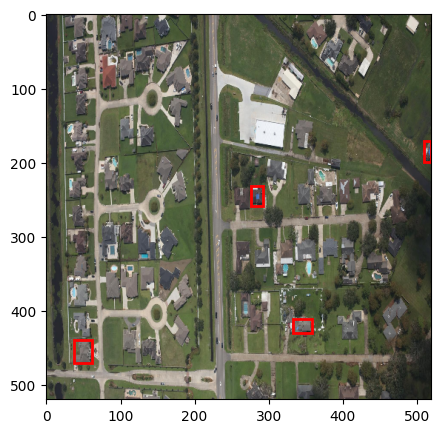

In [4]:
# Function to visualize bounding boxes in the image

def plot_img_bbox(img, target):
    # plot the image and bboxes
    # Bounding boxes are defined as follows: x-min y-min width height
    fig, a = plt.subplots(1,1)
    fig.set_size_inches(5,5)
    a.imshow(img)
    for box in (target['boxes']):
        x, y, width, height  = box[0], box[1], box[2]-box[0], box[3]-box[1]
        rect = patches.Rectangle((x, y),
                                 width, height,
                                 linewidth = 2,
                                 edgecolor = 'r',
                                 facecolor = 'none')

        # Draw the bounding box on top of the image
        a.add_patch(rect)
    plt.show()
    
# plotting the image with bboxes. Feel free to change the index
img, target = dataset[70]
plot_img_bbox(img, target)

In [5]:
def get_object_detection_model(num_classes):

    # load a model pre-trained pre-trained on COCO
    model = torchvision.models.detection.fasterrcnn_resnet50_fpn(pretrained=True)
    # model = torchvision.models.detection.fasterrcnn_resnet50_fpn_v2(pretrained=True)
    
    # get number of input features for the classifier
    in_features = model.roi_heads.box_predictor.cls_score.in_features
    # replace the pre-trained head with a new one
    model.roi_heads.box_predictor = FastRCNNPredictor(in_features, num_classes) 

    return model

def get_transform(train):
    
    if train:
        return A.Compose([
                            A.HorizontalFlip(0.5),
                     # ToTensorV2 converts image to pytorch tensor without div by 255
                            ToTensorV2(p=1.0) 
                        ], bbox_params={'format': 'pascal_voc', 'label_fields': ['labels']})
    else:
        return A.Compose([
                            ToTensorV2(p=1.0)
                        ], bbox_params={'format': 'pascal_voc', 'label_fields': ['labels']})



In [6]:
# use our dataset and defined transformations
dataset = FEMAImagesDataset(files_dir, width, height, transforms= get_transform(train=True))
dataset_test = FEMAImagesDataset(files_dir, width, height, transforms= get_transform(train=False))

# split the dataset in train and test set
torch.manual_seed(1)
indices = torch.randperm(len(dataset)).tolist()

# train test split
tsize = int(len(dataset)*test_split)
dataset = torch.utils.data.Subset(dataset, indices[:-tsize])
dataset_test = torch.utils.data.Subset(dataset_test, indices[-tsize:])

# define training and validation data loaders
data_loader = torch.utils.data.DataLoader(
    dataset, batch_size=5, shuffle=True, num_workers=4,
    collate_fn=utilities.utils.collate_fn)

data_loader_test = torch.utils.data.DataLoader(
    dataset_test, batch_size=5, shuffle=False, num_workers=4,
    collate_fn=utilities.utils.collate_fn)

In [7]:
# device = torch.device('cuda') if torch.cuda.is_available() else torch.device('cpu')
device = torch.device('cpu')

# get the model using our helper function
model = get_object_detection_model(num_classes)

# move model to the right device
model.to(device)

# construct an optimizer
params = [p for p in model.parameters() if p.requires_grad]
optimizer = torch.optim.SGD(params, lr=0.001,
                            momentum=0.9, weight_decay=0.0005)

# and a learning rate scheduler which decreases the learning rate by
# 10x every 3 epochs
lr_scheduler = torch.optim.lr_scheduler.StepLR(optimizer,
                                               step_size=3,
                                               gamma=0.1)

In [8]:
# training for 10 epochs
for epoch in range(num_epochs):
    # training for one epoch
    train_one_epoch(model, optimizer, data_loader, device, epoch, print_freq=10)
    # update the learning rate
    lr_scheduler.step()
    # evaluate on the test dataset
    evaluate(model, data_loader_test, device=device)

Epoch: [0]  [ 0/29]  eta: 0:06:26  lr: 0.000037  loss: 0.0771 (0.0771)  loss_classifier: 0.0000 (0.0000)  loss_box_reg: 0.0000 (0.0000)  loss_objectness: 0.0700 (0.0700)  loss_rpn_box_reg: 0.0072 (0.0072)  time: 13.3322  data: 0.2857  max mem: 0
Epoch: [0]  [10/29]  eta: 0:04:08  lr: 0.000393  loss: 0.1665 (0.1837)  loss_classifier: 0.0000 (0.0000)  loss_box_reg: 0.0000 (0.0000)  loss_objectness: 0.1499 (0.1667)  loss_rpn_box_reg: 0.0077 (0.0169)  time: 13.0783  data: 0.0320  max mem: 0
Epoch: [0]  [20/29]  eta: 0:01:58  lr: 0.000750  loss: 0.1615 (0.1741)  loss_classifier: 0.0000 (0.0000)  loss_box_reg: 0.0000 (0.0000)  loss_objectness: 0.1449 (0.1541)  loss_rpn_box_reg: 0.0115 (0.0200)  time: 13.1839  data: 0.0058  max mem: 0
Epoch: [0]  [28/29]  eta: 0:00:13  lr: 0.001000  loss: 0.1177 (0.1549)  loss_classifier: 0.0000 (0.0000)  loss_box_reg: 0.0000 (0.0000)  loss_objectness: 0.1062 (0.1362)  loss_rpn_box_reg: 0.0115 (0.0187)  time: 13.1567  data: 0.0049  max mem: 0
Epoch: [0] Total

In [9]:
def apply_nms(orig_prediction, iou_thresh=0.00001):
    
    # torchvision returns the indices of the bboxes to keep
    keep = torchvision.ops.nms(orig_prediction['boxes'], orig_prediction['scores'], iou_thresh)
    
    final_prediction = orig_prediction
    final_prediction['boxes'] = final_prediction['boxes'][keep]
    final_prediction['scores'] = final_prediction['scores'][keep]
    final_prediction['labels'] = final_prediction['labels'][keep]
    
    return final_prediction

# function to convert a torchtensor back to PIL image
def torch_to_pil(img):
    return torchtrans.ToPILImage()(img).convert('RGB')

In [10]:
# pick one image from the test set
img, target = dataset[25]
# put the model in evaluation mode
model.eval()
with torch.no_grad():
    prediction = model([img.to(device)])[0]
    
print('predicted #boxes: ', len(prediction['labels']))
print('real #boxes: ', len(target['labels']))

predicted #boxes:  0
real #boxes:  3


EXPECTED OUTPUT


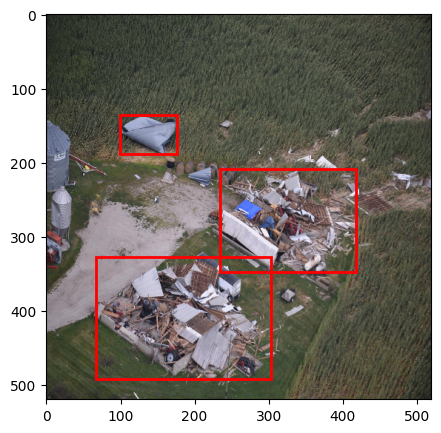

In [11]:
print('EXPECTED OUTPUT')
plot_img_bbox(torch_to_pil(img), target)

MODEL OUTPUT


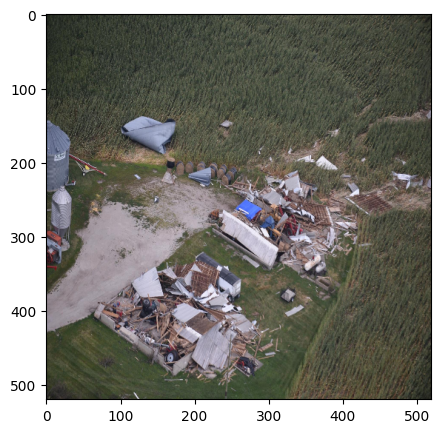

In [12]:
print('MODEL OUTPUT')
plot_img_bbox(torch_to_pil(img), prediction)

NMS APPLIED MODEL OUTPUT


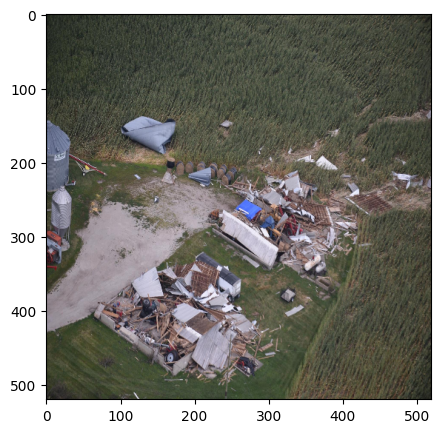

In [13]:
nms_prediction = apply_nms(prediction, iou_thresh=0.2)
print('NMS APPLIED MODEL OUTPUT')
plot_img_bbox(torch_to_pil(img), nms_prediction)